# Twitter Sentiment Analysis

# Step 1 - Collection of Tweets

In [1]:
# Importing libraries

import tweepy
from textblob import TextBlob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import wordcloud
import os
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from textblob import Word
import string
import re
import emoji
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import mglearn
import pyLDAvis.sklearn

C:\Users\prateek\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Initializing the keys
consumer_key = "eYUEuIDFTHVqld8QnRqgP0uV7"
consumer_key_secret = "kA6r8hH5CLtbe5HIoqChte3ZwdDbMMvANIGDgFJPMUypMDPtq6"
access_token = "558743081-2PVVy8tijkJF1ieHGNa115BG3DDdYNJr8UA2gen2"
access_token_secret = "kpZP1ha6eGZI4KkWobZDKgADJveqKuPAzergYte9W7RwW"

In [3]:
# Setup tweepy with Twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
# Create a hashtags list
hashtags = ["#covidclasses", \
            "#schoolathome",     \
            "#virtuallearning",  \
            "#DigitalLearning",  \
            "#schoolfromhome", \
            "#studyfromhome", \
            "#pandemiceducation", \
            "#pandemiclearning", \
            "#learnfromhome"]

In [5]:
# Define a function to get tweets
def get_tweets(search, isHashtag):
    
    # Create a pandas DataFrame
    df_temp = pd.DataFrame(columns=["Content", "Location", "Retweet-Count", "Favorites", "Created at"])
    
    # Get the tweets
    tweets = tweepy.Cursor(api.search, q= search + " -filter:retweets", lang="en", tweet_mode='extended').items(1000)
    
    # Iterate over tweets
    for tweet in tweets:
        content = tweet.full_text
        location = tweet.user.location
        created_at = tweet.created_at
        retweetcount = tweet.retweet_count
        favorites = tweet.favorite_count
        
        # Create a list of the features
        retrieved = [content, location, retweetcount, favorites, created_at]
        
        # Append list to the DataFrame
        df_temp.loc[len(df_temp)] = retrieved
        
    # Generate unique filename
    path = os.getcwd()
    
    # Generate a filename for hashtags
    if isHashtag:
        filename = path + '/output/' + search[1:] + '_hashtag.csv'
    # Save the csv file
    df_temp.to_csv(filename)


### The following cell must be run if tweets have to be fetched. Since I have already fetched my tweets and stored them in .csv files, I have commented the code.

In [ ]:
# Fetching tweets for specified hashtags
#for hashtag in hashtags:
#    get_tweets(hashtag, isHashtag=True)

In [6]:
# Concatenate the DataFrames and save as corpus

# Get csv file names in output directory
path = os.getcwd() + "/output/"
files = os.listdir(path)

# Create a list to store DataFrames
df_list = []

# Iterate over files in output directory and append DataFrames into df_list
for file in files:
    df = pd.read_csv(path + file, index_col=None)
    df_list.append(df)

# Create a DataFrame
tweets_raw = pd.concat(df_list, axis=0, ignore_index=True)

# Save the DataFrame as a csv file
tweets_raw.to_csv("tweets_raw.csv")

In [7]:
# Get count of all columns
tweets_raw.count()

Unnamed: 0       1702
Content          1702
Location         1371
Retweet-Count    1702
Favorites        1702
Created at       1702
dtype: int64

# Step 2 - Labelling

## TextBlob

In [8]:
# TextBlob polarity

tweets_raw["TextBlob_Polarity"] = tweets_raw["Content"].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

In [9]:
# Top 10 positive tweets based on TextBlob
top_positive = tweets_raw.sort_values('TextBlob_Polarity', ascending=False).head(10)

In [10]:
# Top 10 negative tweets based on TextBlob
top_negative = tweets_raw.sort_values('TextBlob_Polarity', ascending=True).head(10)

In [11]:
# Inspecting positive tweet
print(top_positive['Content'].iloc[0])

@morelandprimary Pine Class really impressed us today, using Toontastic 3D to showcase their story telling skills &amp; their Kings, Queens &amp; Castles term topic. 
#IslingtonSchools #VirtualLearning #Cartoons #StoryTelling https://t.co/1TLsm8YHGd


In [12]:
# Inspecting negative tweet
print(top_negative['Content'].iloc[3])

#EDUCATION: Is #VirtualLearning merely a stopgap during #COVID19 or will it be a permanent part of #learning going forward?

https://t.co/sWw2o82VAh

#school #students #DistanceLearning #Online https://t.co/D00ksFr3Eo


## VADER

In [13]:
# Initializing sentiment analyzer and downloading VADER lexicon
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\prateek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
# Vader polarity score
tweets_raw['vader_polarity_score'] = tweets_raw["Content"].apply(lambda tweet: sid.polarity_scores(tweet))

In [15]:
# Vader compound polarity
tweets_raw['compound_polarity'] = tweets_raw['vader_polarity_score'].apply(lambda score_dict: score_dict['compound'])

In [266]:
# Inspecting dataframe
tweets_raw.head(10)

,Unnamed: 0,Content,Location,Retweet-Count,Favorites,Created at,TextBlob_Polarity,vader_polarity_score,compound_polarity,Sentiment_Type,sentiment_score
0,0,🧑‍💻How we’re engaging students in real-time co...,"London, UK",1,1,2021-03-16 19:10:03,0.400000,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.3400,Positive,2
1,1,Barclays LifeSkills gives you the knowledge an...,Gloucestershire,0,0,2021-03-16 19:05:12,0.136364,"{'neg': 0.0, 'neu': 0.81, 'pos': 0.19, 'compou...",0.7269,Positive,2
2,2,Enlightenment Stations for tomorrow! \nTemplat...,"Smithfield, VA",0,3,2021-03-16 18:30:25,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,1
3,3,As Israel comes upon its 24th parliamentary el...,NaN,0,0,2021-03-16 18:07:00,0.083333,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,1
4,4,A1: Some of my amazing mentors and friends in ...,Michigan,0,1,2021-03-16 17:38:11,0.575000,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...",0.8016,Positive,2
5,5,Q1: Let’s kick things off by mentioning some f...,"Boston, MA",2,5,2021-03-16 17:35:05,0.000000,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'comp...",0.6467,Positive,2
6,6,Hello #California #K12 #District Leaders - sti...,"Irvine, California",0,0,2021-03-16 17:32:17,0.416667,"{'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compou...",0.7351,Positive,2
7,7,"One module 2 @alHamir #edtech, #elearning, #ed...",lagos,1,1,2021-03-16 17:31:50,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,1
8,8,"Started module 2 already #edtech, #elearning, ...",NaN,0,2,2021-03-16 17:28:58,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,1
9,9,"In this #TechForGood exclusive, @SusanWard30, ...",NaN,0,0,2021-03-16 17:16:51,0.000000,"{'neg': 0.0, 'neu': 0.947, 'pos': 0.053, 'comp...",0.1280,Positive,2


In [17]:
# Top 10 positive tweets based on VADER
top_positive_vader = tweets_raw.sort_values('compound_polarity', ascending=False).head(10)

In [18]:
# Inspecting positive tweet
print(top_positive_vader['Content'].iloc[9])

There’s still space to book for tomorrow’s FREE online Creative Composing Lab,  inspired by Birtwistle's Pulse Sampler. Sign up below - a great opportunity for young composers living both in and outside of Brum!
https://t.co/W91Oo1952N
#NewMusic #digitallearning #composing


In [19]:
# Top 10 negative tweets based on VADER
top_negative_vader = tweets_raw.sort_values('compound_polarity', ascending=True).head(10)

In [20]:
# Inspecting negative tweet
print(top_negative_vader['Content'].iloc[9])

Report cards are giving educators a concrete indicator of just how much learning loss our local students have suffered during the pandemic and shutdown orders, and the learning loss is real. Watch now:https://t.co/5rwkv0wH6U #PandemicLearning @DesertSandsUSD @PSUSD @CVUnified


In [21]:
# Adding sentiment type based on vader polarity
tweets_raw['Sentiment_Type'] = np.where(tweets_raw.loc[:,'compound_polarity'] > 0, "Positive", np.where(tweets_raw.loc[:,'compound_polarity'] < 0,"Negative","Neutral"))

In [22]:
# Inspecting dataframe
tweets_raw.head()

,Unnamed: 0,Content,Location,Retweet-Count,Favorites,Created at,TextBlob_Polarity,vader_polarity_score,compound_polarity,Sentiment_Type
0,0,🧑‍💻How we’re engaging students in real-time co...,"London, UK",1,1,2021-03-16 19:10:03,0.400000,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.3400,Positive
1,1,Barclays LifeSkills gives you the knowledge an...,Gloucestershire,0,0,2021-03-16 19:05:12,0.136364,"{'neg': 0.0, 'neu': 0.81, 'pos': 0.19, 'compou...",0.7269,Positive
2,2,Enlightenment Stations for tomorrow! \nTemplat...,"Smithfield, VA",0,3,2021-03-16 18:30:25,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
3,3,As Israel comes upon its 24th parliamentary el...,NaN,0,0,2021-03-16 18:07:00,0.083333,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,4,A1: Some of my amazing mentors and friends in ...,Michigan,0,1,2021-03-16 17:38:11,0.575000,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...",0.8016,Positive


In [23]:
# Encoding sentiment type

le = LabelEncoder()
tweets_raw['sentiment_score'] = le.fit_transform(tweets_raw['Sentiment_Type'])

### 0 --> Negative
### 1 --> Neutral
### 2 --> Positive

In [24]:
tweets_raw.head()

,Unnamed: 0,Content,Location,Retweet-Count,Favorites,Created at,TextBlob_Polarity,vader_polarity_score,compound_polarity,Sentiment_Type,sentiment_score
0,0,🧑‍💻How we’re engaging students in real-time co...,"London, UK",1,1,2021-03-16 19:10:03,0.400000,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.3400,Positive,2
1,1,Barclays LifeSkills gives you the knowledge an...,Gloucestershire,0,0,2021-03-16 19:05:12,0.136364,"{'neg': 0.0, 'neu': 0.81, 'pos': 0.19, 'compou...",0.7269,Positive,2
2,2,Enlightenment Stations for tomorrow! \nTemplat...,"Smithfield, VA",0,3,2021-03-16 18:30:25,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,1
3,3,As Israel comes upon its 24th parliamentary el...,NaN,0,0,2021-03-16 18:07:00,0.083333,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,1
4,4,A1: Some of my amazing mentors and friends in ...,Michigan,0,1,2021-03-16 17:38:11,0.575000,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...",0.8016,Positive,2


## Step 3 - Preprocessing and running models

In [220]:
# Defining preprocessing function
def preprocessing(text):
    # Removing links and hashtags and tags and emojis 
    
    regxp_emoji = emoji.get_emoji_regexp()
    text = text.str.replace(regxp_emoji,'', regex=True)
    text = text.str.replace(r"http\S+|www\S+|https\S+", '', regex=True)
    text = text.str.replace(r'@\S+','', regex=True)
    text = text.str.replace(r'#\S+','', regex=True)
    text = text.str.replace('&amp;', '&')
    text = text.str.replace(r'^\d+\s|\s\d+\s|\s\d+$', '', regex=True)
    
    
    
    
    # Removing punctuation
    exclude = set(string.punctuation)
    pd.Series(text).apply(lambda x: " ".join(x for x in x.split() if x not in exclude))
    # Applying lemmatization on the summary text column
    pd.Series(text).apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return text

In [221]:
# Counting no of tweets
tweets_raw['Content'].count()

1648

In [222]:
# Count of unique tweets
tweets_raw['Content'].nunique()

1648

In [223]:
# Dropping duplicates
tweets_raw.drop_duplicates('Content', inplace=True)

In [224]:
# Final count of tweets
tweets_raw['Content'].count()

1648

In [225]:
# Splitting dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(tweets_raw['Content'], tweets_raw['sentiment_score'], test_size = 0.2, random_state = 42)

In [226]:
X_train = preprocessing(X_train)

## SGD Classifier

In [230]:
# Pipeline for SGD Classifier
sgd_pipeline = make_pipeline(TfidfVectorizer(), SGDClassifier())

param_grid = {'sgdclassifier__alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.01],
              "tfidfvectorizer__ngram_range": [(1, 1), (2, 2)],
             'tfidfvectorizer__stop_words': ["english", None],
              'tfidfvectorizer__lowercase': [True, False]
             }

grid = GridSearchCV(sgd_pipeline, param_grid)

In [231]:
# Fitting grid search to training set
grid.fit(X_train, y_train)

C:\Users\prateek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                          

In [232]:
# Printing best cross validation score and best parameters

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.76
Best parameters:
{'sgdclassifier__alpha': 0.0001, 'tfidfvectorizer__lowercase': True, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': None}


In [233]:
# Running model on test set
pred = grid.predict(X_test)

In [234]:
# Printing accuracy on test data
accuracy_score(y_test,pred)

0.7878787878787878

In [235]:
# Initializing classification report
sgd_cr = classification_report(y_test, pred)

In [236]:
# Printing classification report
print(sgd_cr)

              precision    recall  f1-score   support

           0       0.80      0.18      0.30        22
           1       0.75      0.52      0.61        83
           2       0.79      0.95      0.86       225

    accuracy                           0.79       330
   macro avg       0.78      0.55      0.59       330
weighted avg       0.78      0.79      0.76       330



## Logistic Regression

In [237]:
# Pipeline for Logistic Regression
logistic_pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())

log_param_grid = {'logisticregression__C': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (2, 2)],
             'tfidfvectorizer__stop_words': ["english", None],
              'tfidfvectorizer__lowercase': [True, False]
             }

log_grid = GridSearchCV(sgd_pipeline, param_grid)

In [238]:
# Fitting grid search to training set
log_grid.fit(X_train, y_train)

C:\Users\prateek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                          

In [240]:
# Printing best cross validation score and best parameters

print("Best cross-validation score: {:.2f}".format(log_grid.best_score_))
print("Best parameters:\n{}".format(log_grid.best_params_))

Best cross-validation score: 0.76
Best parameters:
{'sgdclassifier__alpha': 0.0001, 'tfidfvectorizer__lowercase': True, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': None}


In [241]:
# Running model on test data
log_pred = log_grid.predict(X_test)

In [242]:
# Printing accuracy on test data

accuracy_score(y_test,log_pred)

0.7848484848484848

In [243]:
# Initializing classification report
log_cr = classification_report(y_test, log_pred)

In [244]:
# Printing classification report
print(log_cr)

              precision    recall  f1-score   support

           0       0.80      0.18      0.30        22
           1       0.73      0.53      0.62        83
           2       0.80      0.94      0.86       225

    accuracy                           0.78       330
   macro avg       0.78      0.55      0.59       330
weighted avg       0.78      0.78      0.76       330



## Step 4 - Topic modeling and visualization

In [267]:
# Copying dataset
tweets_new = tweets_raw.copy()

In [268]:
# Preprocessing data
tweets_new['Content'] = preprocessing(tweets_new['Content'])

In [269]:
# Printing count of tweets based on sentiment type
tweets_new['Sentiment_Type'].value_counts()

Positive    1122
Neutral      428
Negative      98
Name: Sentiment_Type, dtype: int64

In [270]:
# Extracting positive tweets
positive_tweets = tweets_new[tweets_new['Sentiment_Type'] == "Positive"]

In [271]:
# Extracting negative tweets
negative_tweets = tweets_new[tweets_new['Sentiment_Type'] == "Negative"]

In [273]:
# LDA initialization

lda_pos = LatentDirichletAllocation(n_components=20, max_iter=25, learning_method='batch')
lda_neg = LatentDirichletAllocation(n_components=20, max_iter=25, learning_method='batch')

In [275]:
# Vectorizing data

cv_pos = CountVectorizer(stop_words="english").fit(positive_tweets['Content'])
count_vect_pos = cv_pos.transform(positive_tweets['Content'])

cv_neg = CountVectorizer(stop_words="english").fit(negative_tweets['Content'])
count_vect_neg = cv_neg.transform(negative_tweets['Content'])


In [276]:
# Fitting LDA model to positive reviews
pos_topics = lda_pos.fit_transform(count_vect_pos)

In [277]:
# Extracting feature names and applying sorting

feature_names_pos = np.array(cv_pos.get_feature_names())
sorting = np.argsort(lda_pos.components_, axis=1)[:, ::-1]

In [287]:
# Printing out 20 topics
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names_pos,
                            sorting=sorting,topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
meeting       learning      know          free          virtual       
program       benefits      speak         online        face          
virtual       work          tips          join          international 
training      year          visit         register      time          
students      today         information   demo          learn         
today         join          help          march         visit         
add           article       journey       visit         great         
microsoft     class         work          virtual       join          
dm            employees     coach         classes       hybrid        
kids          group         did           trial         student       
like          grid          employment    00            free          
skills        long          jcp           learning      lesson        
certif

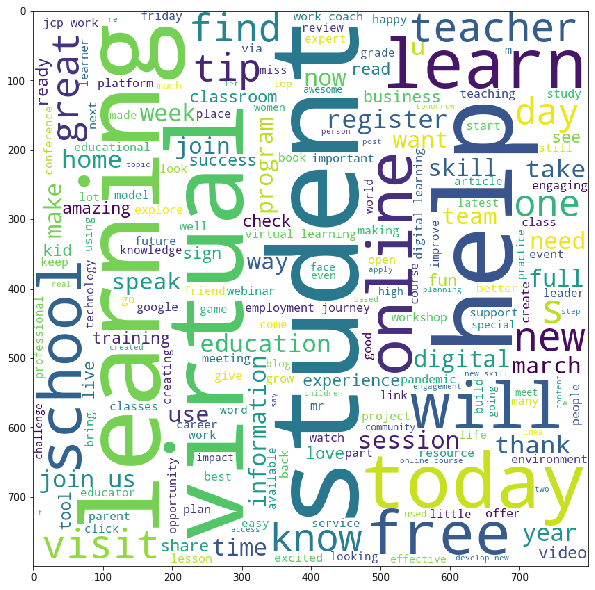

In [279]:
# Plotting word cloud for positive sentiment
from wordcloud import WordCloud


comment_words = '' 
# Iterating through the reviews
for val in positive_tweets['Content']: 
      
    # typecaste each review to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(comment_words) 
  
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [280]:
# Fitting LDA model to negative reviews
neg_topics = lda_neg.fit_transform(count_vect_neg)

In [281]:
# Getting feature names and applying sorting
feature_names_neg = np.array(cv_neg.get_feature_names())
sorting_neg = np.argsort(lda_neg.components_, axis=1)[:, ::-1]

In [288]:
# Printing out 20 topics
import mglearn
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names_neg,
                            sorting=sorting_neg,topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
international people        online        today         school        
vol           solutions     biomedical    don           glass         
journal       don           engineering   need          people        
emerging      sure          2020          make          need          
ijet          critical      ijoe          virtual       moment        
technologies  agenda        workin        miss          working       
learning      straight      16            register      tears         
16            virtual       international learning      playing       
2021          broadband     vol           start         isolation     
couldn        face          journal       level         focus         
went          read          shows         point         music         
play          listening     sure          new           edit          
classe

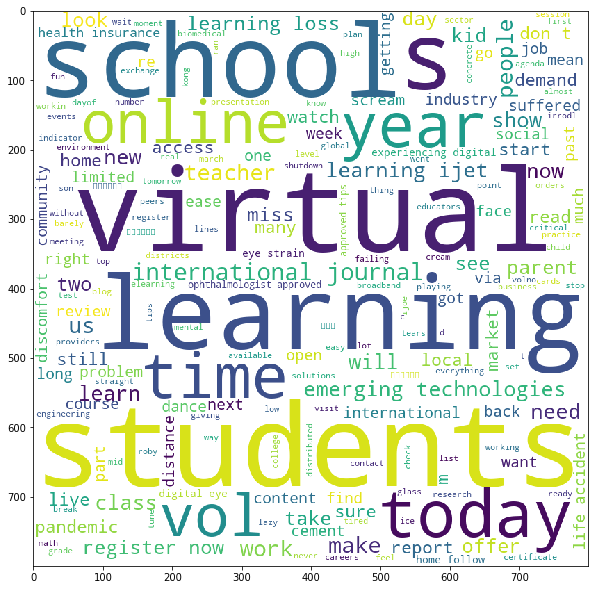

In [283]:
# Plotting word cloud for negative sentiment
from wordcloud import WordCloud


comment_words = '' 
# Iterating through the reviews
for val in negative_tweets['Content']: 
      
    # typecaste each review to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(comment_words) 
  
# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [285]:
# pyLDAvis for positive tweets
panel = pyLDAvis.sklearn.prepare(lda_pos, count_vect_pos, cv_pos, mds='tsne')
pyLDAvis.display(panel)

In [286]:
# pyLDAvis for negative tweets
panel_neg = pyLDAvis.sklearn.prepare(lda_neg, count_vect_neg, cv_neg, mds='tsne')
pyLDAvis.display(panel_neg)